# WEIGHTED K-MEANS CLUSTERING

We apply the weighted version of the K-means clustering algorithm. The algorithm clusters each point using the Euclidean distance between points. In the weighted version, we use the duration of each stop (point) as the weight. In this way, the points/stops with a longer duration are more "important". In the algorithm, this is translated such that these points appear more often, therefore when recalculating the central position of the cluster, they have more weight. 

The K-means algorithm works as follows:

    1. We choose the number of desired clusters K. The algorithm randomly choose "K" points of the datas as the centroids of each cluster.
    
    2. In the first iteration, the algorithm calculates the distance from each point to each centroid, and assign each data point to the closest cluster (shortest Euclidean distance). 
    
    3. Then, K clusters are formed and the position of the centroid (of each cluster) is re-calculated as the average position of the data-points in the cluster. 
    
    4. The algorithm continues iterating, re-assigning the points to the correct clusters and re-calculating the positions of the centroids, until it converges (the positions of the centroids no longer change or they do below a small threshold). Therefore the K clusters are quite constant.


<br>

1. The K-means need the number of K clusters we desire as an input. For this reason, we apply three common methods to the determine the number of optimal clusters (Elbow method point, Silhouette analysis and GAP statistic method). We find K=7 as the optimal number of clusters.


2. Afterwards, we apply the algorithm and perform a simple analysis:  clusters representation and statistics. 
 
 
3. Finally, we apply the un-weighted version of the algorithm for robustness. We check that weighting the stops by their duration does not modify the clustering results at all (only 1 of the 68 stops is regrouped in a different cluster).

In [2]:
from gpxcsv import gpxtolist
import pandas as pd
import networkx as nx
import osmnx as ox


import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from math import sin, cos, sqrt, atan2, radians
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from folium import Map
from folium.plugins import HeatMap, HeatMapWithTime
import utm
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from scipy.stats import gaussian_kde
from shapely.geometry import Point, LineString, Polygon
import folium

import utm
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from gap_statistic import OptimalK

from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj
from matplotlib.patches import Rectangle



#%matplotlib notebook
#matplotlib inline
#ox.config(use_cache=True, log_console=True)
ox.__version__





'1.3.0'

In [3]:
def GPScoordinates_to_utm(lat,lon):
    """" Function that projects the GPS coordinates in degrees (latitude, longitude) into the UTM coordinate system
    in order to work with the concept of "point" and "Euclidean distance" in a plane.
    (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
    
    Note: We are dealing with locations in the same area/region. Otherwise, we should be careful if two locations 
    belong to different UTM zones when calculating distances, etc. 
    
    Input:
        - lists of GPS coordinates: latitude and longitude
        
    Output:
        - lists of the UTM projections of the GPS coordinates: 
        - The utm package returns Easting, Northing, Zone_number and Zone_letter. So we only store the two first elements
    """
    
    lat_utm=[]
    lon_utm=[]
    for i in range(len(lat)):
        u=utm.from_latlon(lat[i],lon[i])  # get the UTM projection
        lat_utm.append(u[0])   # Store the projection of latitude and longitude in lists
        lon_utm.append(u[1])
        
    return lat_utm, lon_utm
        

        

def map_network(lat1,lon1,lat2,lon2,lat3,lon3,lat4,lon4):
    """" Function that creates a map of the urban network from a polygon (given the 4 bounds).
    
    Input:
        - bounds: 4 latitude and longitude points (GPS coordinates)
        
    Output:
        - The figure and the axes.
        
    """
    
    P = Polygon([(lat1,lon1), (lat2,lon2),(lat3,lon3),(lat4,lon4)])  # Create the graph from lat and lon bounds
    G = ox.graph_from_polygon(P, network_type='all') 
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="w",edge_color="#333333", edge_linewidth=1, node_size=0)
    place_name = "Granollers, Vallès Oriental"
    tags={"building": True}
    gdf = ox.geometries_from_place(place_name, tags)
    gdf.shape
    gdf.plot(ax=ax,color='silver',alpha=0.7)
    buildings = ox.geometries_from_place(place_name, tags={'building':True}) # Retrieve buildings from the area:
    
    #for _, edge in ox.graph_to_gdfs(G, nodes=False).fillna('').iterrows():     # Name of the street
        #c = edge['geometry'].centroid
        #text = edge['name']
        #ax.annotate(text, (c.x, c.y), c='w')       
 
    return fig, ax




def buffer_in_meters(lng, lat, radius):
    'Given the gps coordenates and the desired radius (in metres), the function creates a circle around the gps point'
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
    pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)
    
    buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng



def weighted_kmeans(x, k):
    """ 
    K-means algorithm using weights
    """

    x_weight = df_tots2_utm['durada'].tolist()  # Weights: time duration of each stop
    kmeans_weighted = KMeans(k, n_init=100)
    kmeans_weighted.fit(x,sample_weight=x_weight)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return kmeans_weighted.cluster_centers_, kmeans_weighted.predict(x,sample_weight = x_weight)



def unweighted_kmeans(x, k):
    """ 
    Unweighted (classic) K-means algorithm
    """
    
    kmeans_unweighted = KMeans(k, n_init=100)
    kmeans_unweighted.fit(x)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return kmeans_unweighted.cluster_centers_, kmeans_unweighted.predict(x)

# 0. READ AND PROCESS DATA-SET

## 0.1. Read data-set with 68 stops

Originally there were 81 stops due to actions/missions (social-festive activites). However, there are 13 stops located outside the limits of the neighbourhood, which are removed before apply the clustering algorithm

In [4]:
df_stops = pd.read_csv('stops_granollers.csv')

## 0.2. Process the data-set

Convert the latitude and longitude to UTM (2-D projection) in order to work with Euclidean distances (K-means clustering algorithm)

In [5]:
import utm

lat = df_stops['latitud'].tolist()
lon = df_stops['longitud'].tolist()



lat_utm, lon_utm = GPScoordinates_to_utm(lat, lon)

    
df_stops_utm = df_stops.copy()
df_stops_utm['lat_utm'] = lat_utm
df_stops_utm['lon_utm'] = lon_utm

df_stops_utm



#df_stops_utm.to_csv('stops_granollers.csv',index=False)

,accio,color,latitud,longitud,durada,lat utm,lon utm,lat_utm,lon_utm
0,Ce1+CCe1+Me1,seagreen,41.604203,2.282094,985.0,440177.563298,4.606082e+06,440177.563298,4.606082e+06
1,Xe1,darkblue,41.603524,2.281836,521.0,440155.409060,4.606007e+06,440155.409060,4.606007e+06
2,Je1,m,41.603248,2.281657,100.0,440140.237344,4.605976e+06,440140.237344,4.605976e+06
3,Je1,m,41.603673,2.281787,249.0,440151.435778,4.606023e+06,440151.435778,4.606023e+06
4,Be1,red,41.603620,2.281892,151.0,440160.164268,4.606017e+06,440160.164268,4.606017e+06
...,...,...,...,...,...,...,...,...,...
63,Bg7+Cg7+Xg7+Jg7+Mg7,red,41.603630,2.282209,3130.0,440186.578644,4.606018e+06,440186.578644,4.606018e+06
64,Cg8+CCg8+Mg8,seagreen,41.602827,2.281688,656.0,440142.404194,4.605929e+06,440142.404194,4.605929e+06
65,Bg8,red,41.603659,2.282345,918.0,440197.948941,4.606021e+06,440197.948941,4.606021e+06
66,Jg8,m,41.603631,2.282223,713.0,440187.715579,4.606018e+06,440187.715579,4.606018e+06


## 0.3. Select columns to cluster and weight

We use the two columns (latitude and longitude UTM) to cluster. We also get the list of the stops durations to weight each latituge-longitude point. When applying the k-means algorithm, the weights indicate the "frequency" of each point.



In [6]:
x = df_stops_utm.iloc[:,5:7] # Prepare the data (longitude and latitude GPS coordinates in the UTM projection) 
x_weight = df_stops_utm['durada'].tolist()  # Weights: time duration of each stop


<br>


# 1. Weighted K-means cluster algorithm

## 1.1. Number of optimal clusters k

### 1.1.1. Elbow method

The Elbow method consists, for a given number of chosen clusters k, in finding the within-cluster sum of square (WCSS), i.e. the sum of the square distance between points in a cluster and the cluster centroid. 

Then, the WCSS is represented as a function of the number of clusters k. When we see an elbow shape in the graph, we pick the K-value where the elbow gets created. We can call this the elbow point. Beyond the elbow point, increasing the value of ‘K’ does not lead to a significant reduction in WCSS.



C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


1 166006691.42120352


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2 64217059.21628001


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


3 39170128.99066198


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


4 28689719.81762025


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


5 20629331.340649907


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6 15890466.712981116


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


7 11458050.975731594


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


8 9459385.222805817


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


9 7547513.233414011


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


10 6168500.652342368


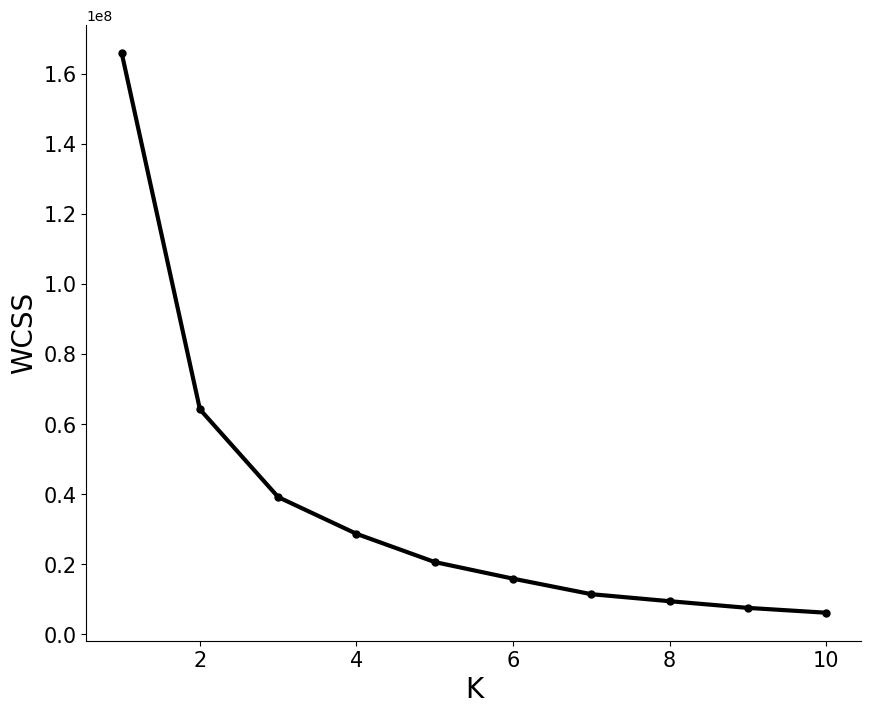

In [7]:
# number of clusters k=1,..,10

wcss = []
ks_list = []

for ks in range(1,11):
    
    kmeans_weighted = KMeans(ks,n_init=100)   # each k-means is applied 500 times in order to find the optimal initial centroids
    kmeans_weighted.fit(x,sample_weight=x_weight)  # use the latitude and longitude (UTM projected) and the weights (duration)
    identified_weighted_clusters = kmeans_weighted.predict(x,sample_weight = x_weight)
    
    wcss_iter = kmeans_weighted.inertia_   # WCSS (within-cluster sum of square)
    wcss.append(wcss_iter)
    
    ks_list.append(ks)
    
    #print(ks, wcss_iter)
    
    
fig, ax = plt.subplots(figsize=(10,8)) 
ax.plot(ks_list,wcss, '.-',c='black',linewidth=3,markersize=10)
ax.set_xlabel('K', fontsize=20)
ax.set_ylabel('WCSS', fontsize=20)
plt.tick_params(labelsize = 15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig('weighted_k_means_elbow.pdf',format='pdf', bbox_inches='tight')

plt.show()    

### 1.1.2. Silhouette method

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For k = 2 The average silhouette_score is : 0.49288808081393526


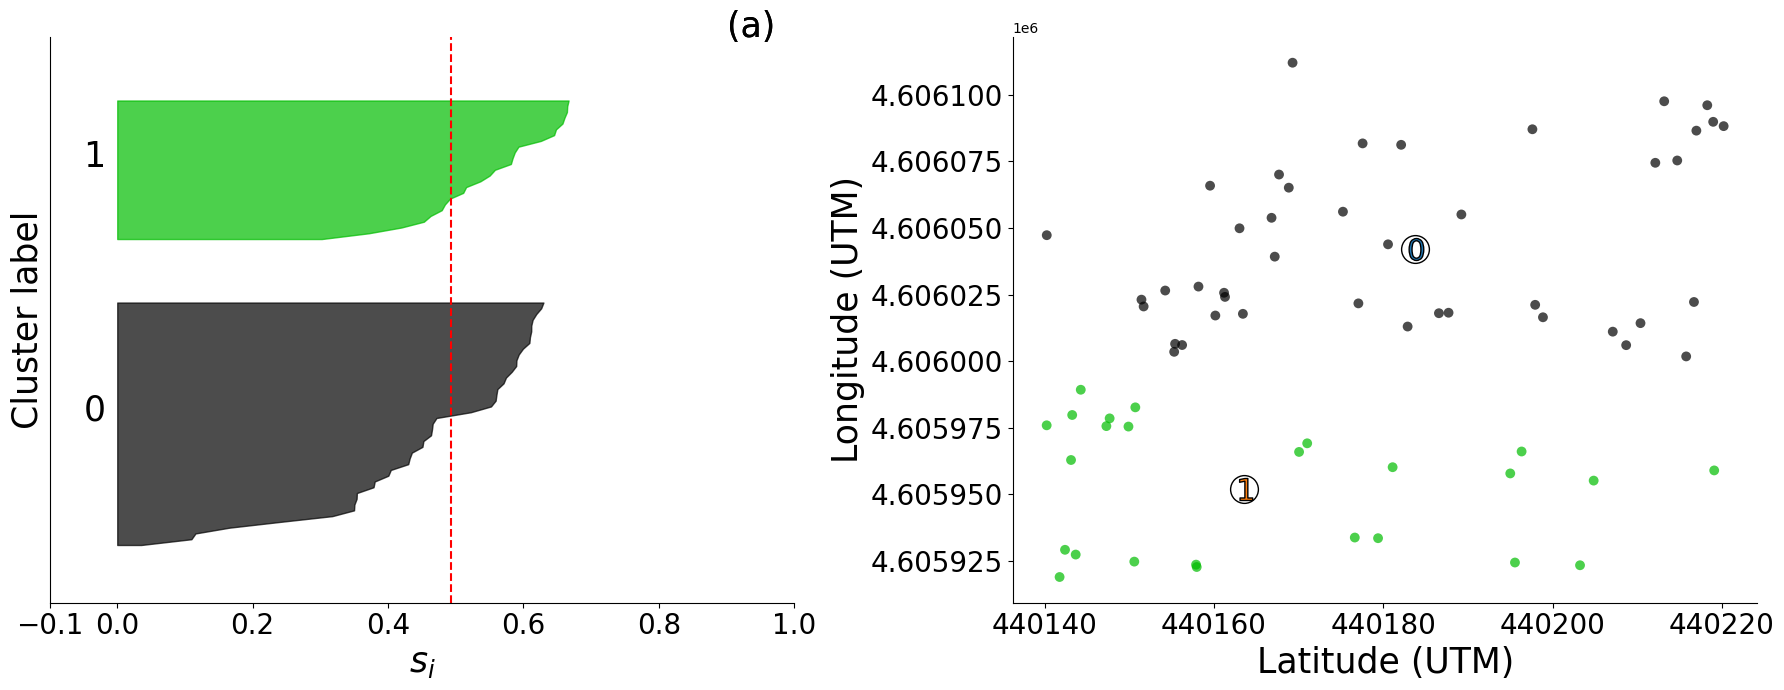

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For k = 3 The average silhouette_score is : 0.4250504336275302


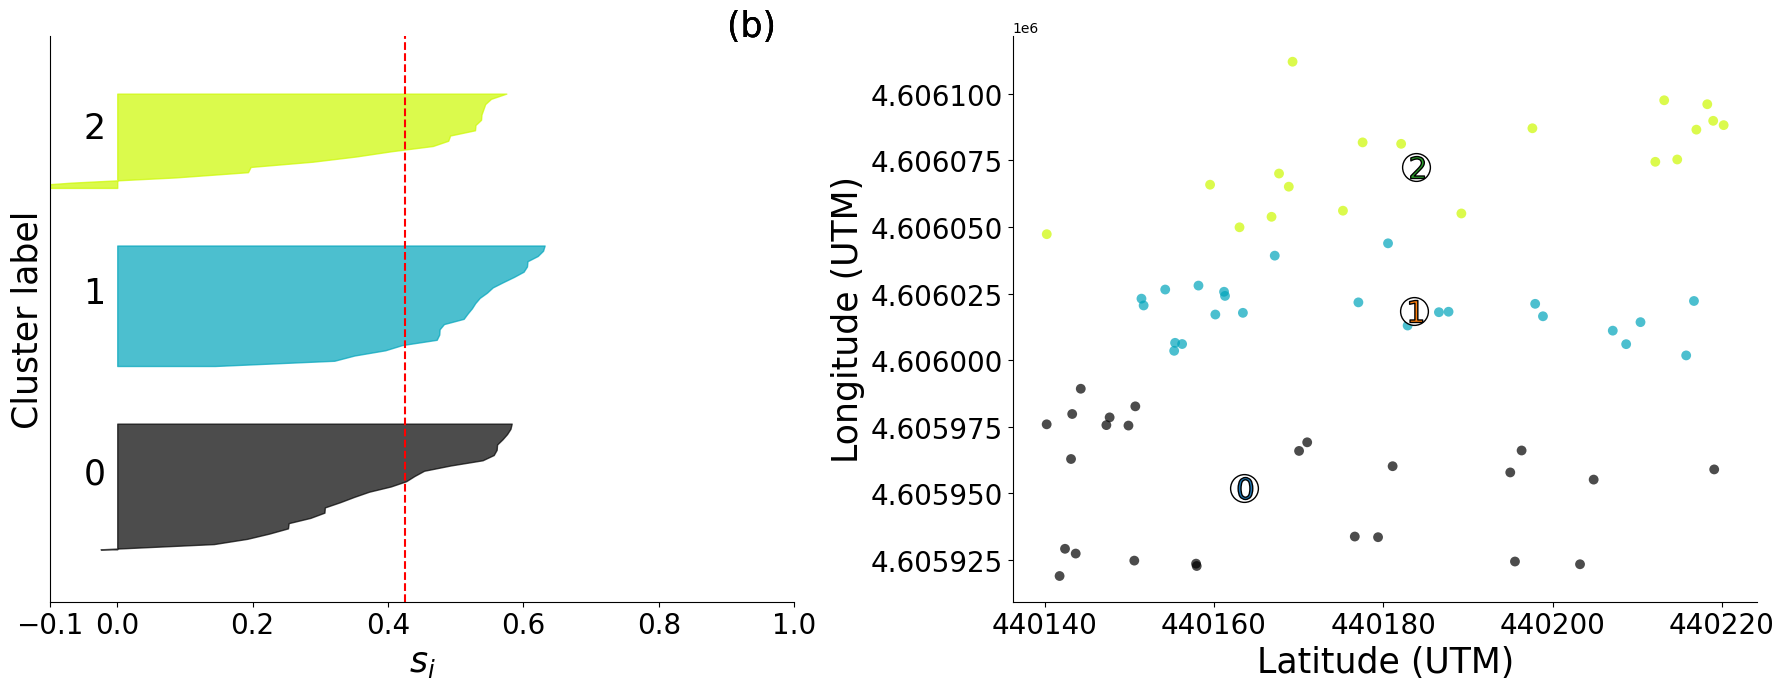

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For k = 4 The average silhouette_score is : 0.3942500956153048


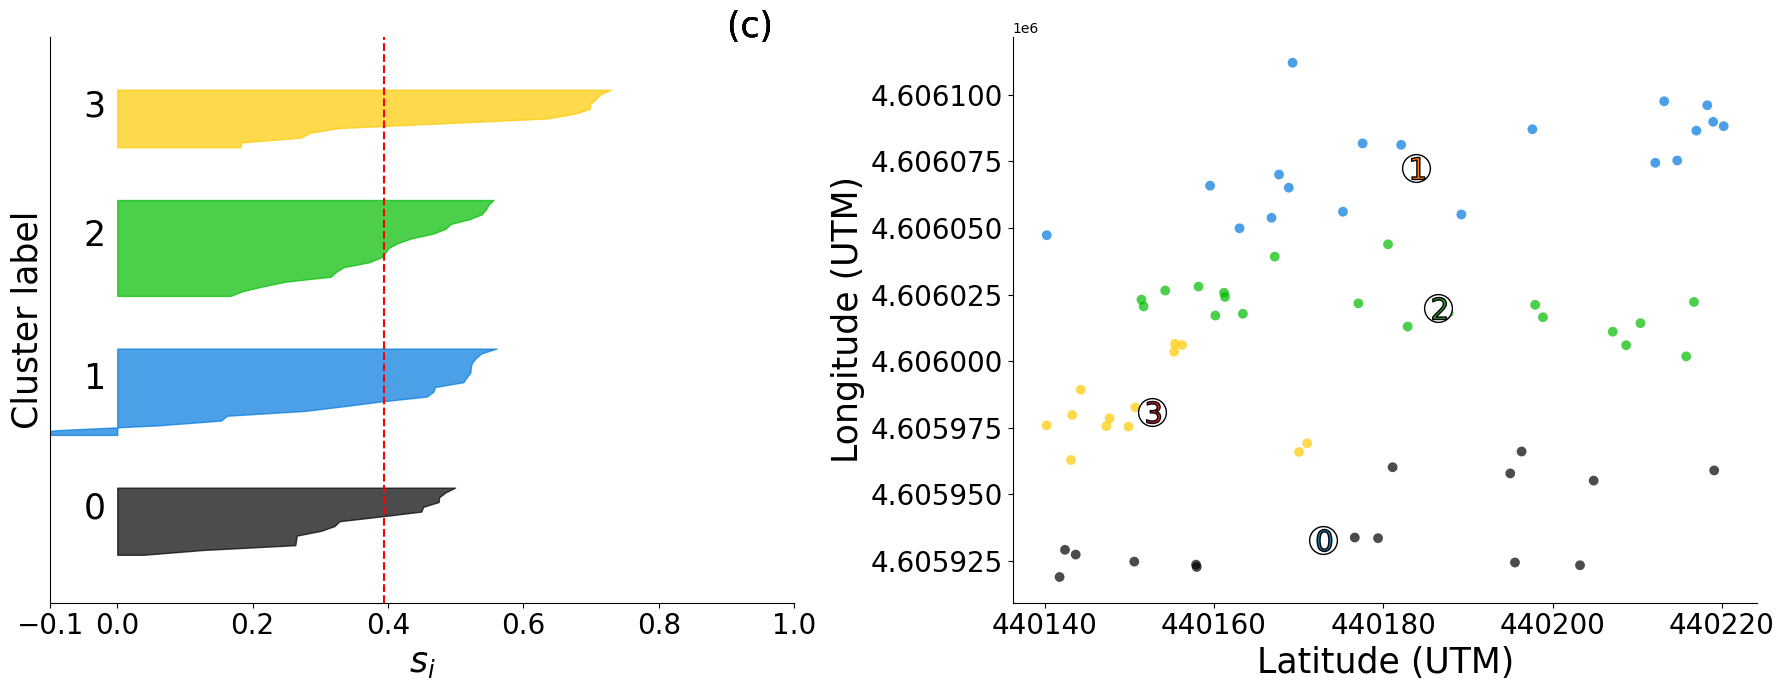

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For k = 5 The average silhouette_score is : 0.4375061517224465


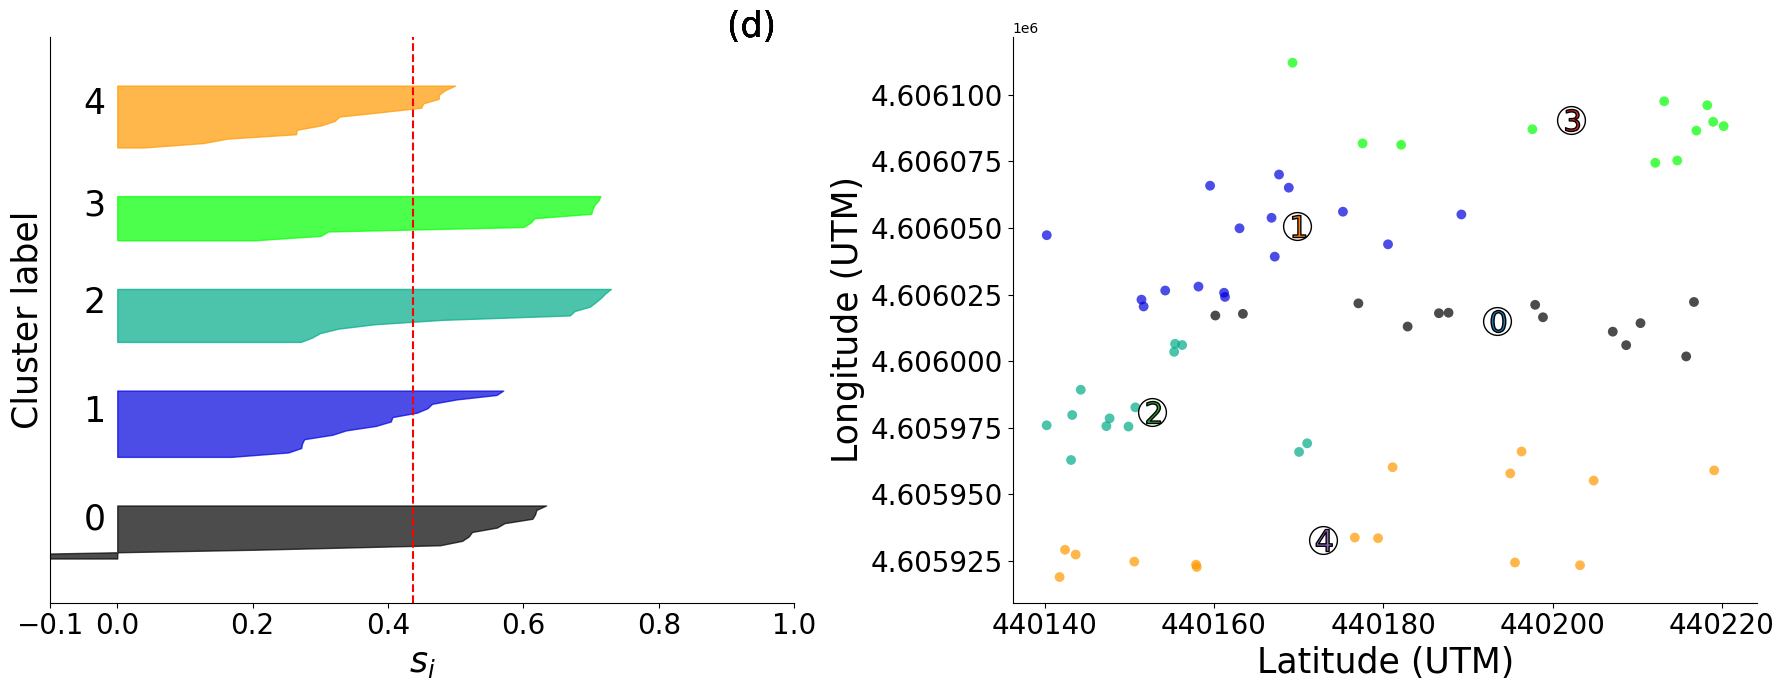

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For k = 6 The average silhouette_score is : 0.444128895024555


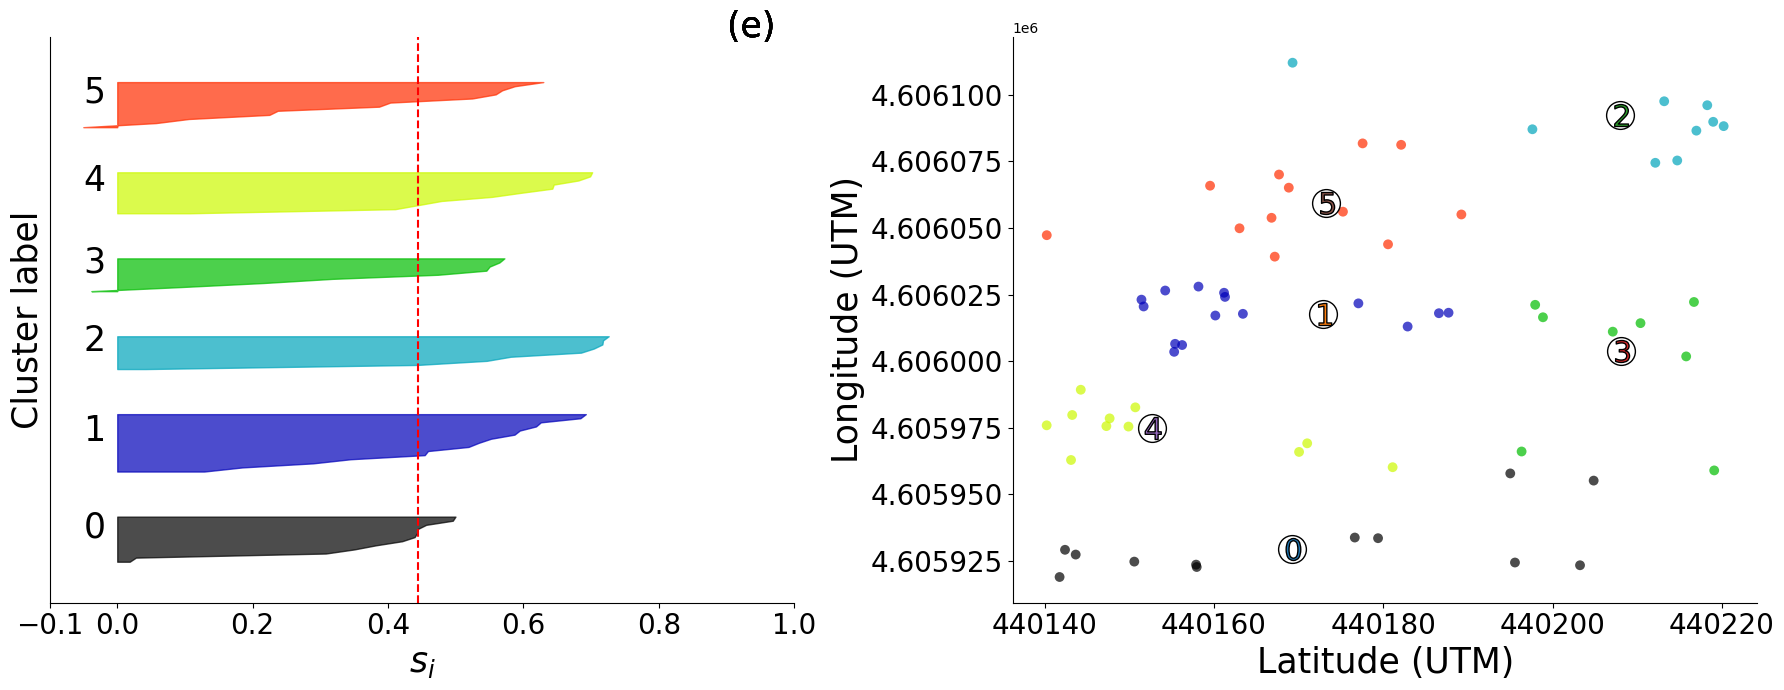

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For k = 7 The average silhouette_score is : 0.5228647437183644


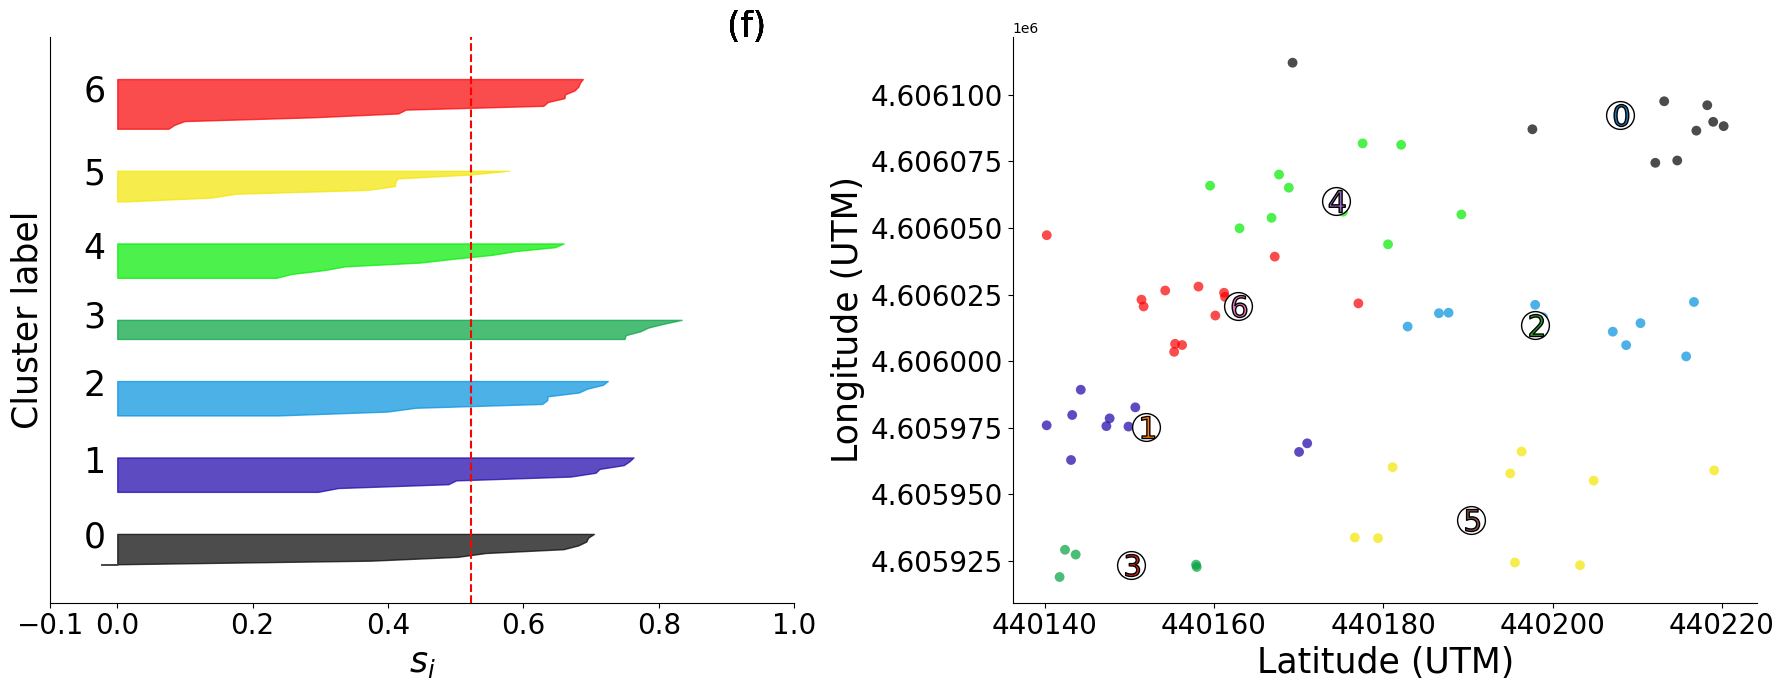

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For k = 8 The average silhouette_score is : 0.5039953083459773


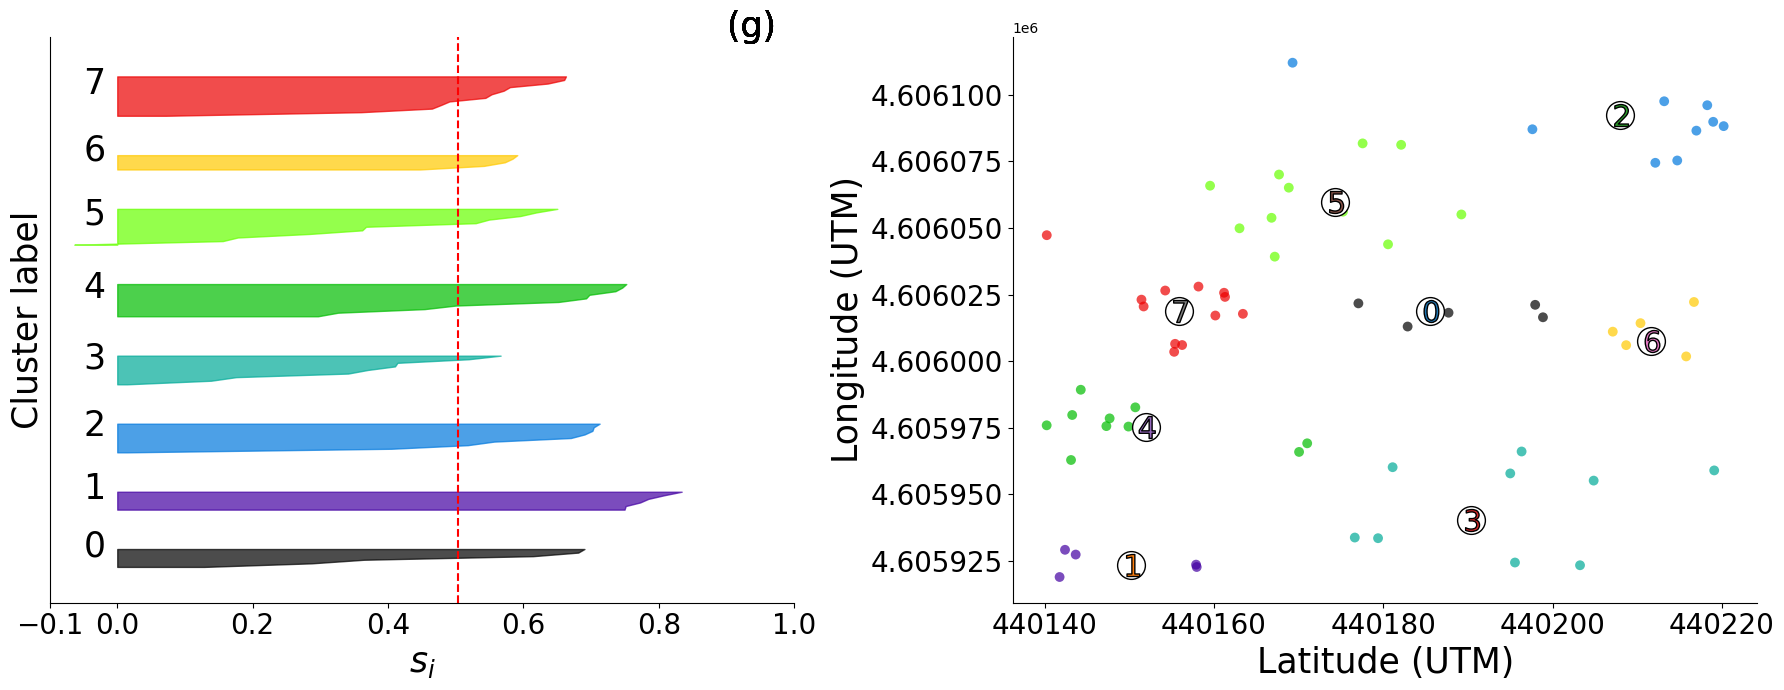

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For k = 9 The average silhouette_score is : 0.5007790844755565


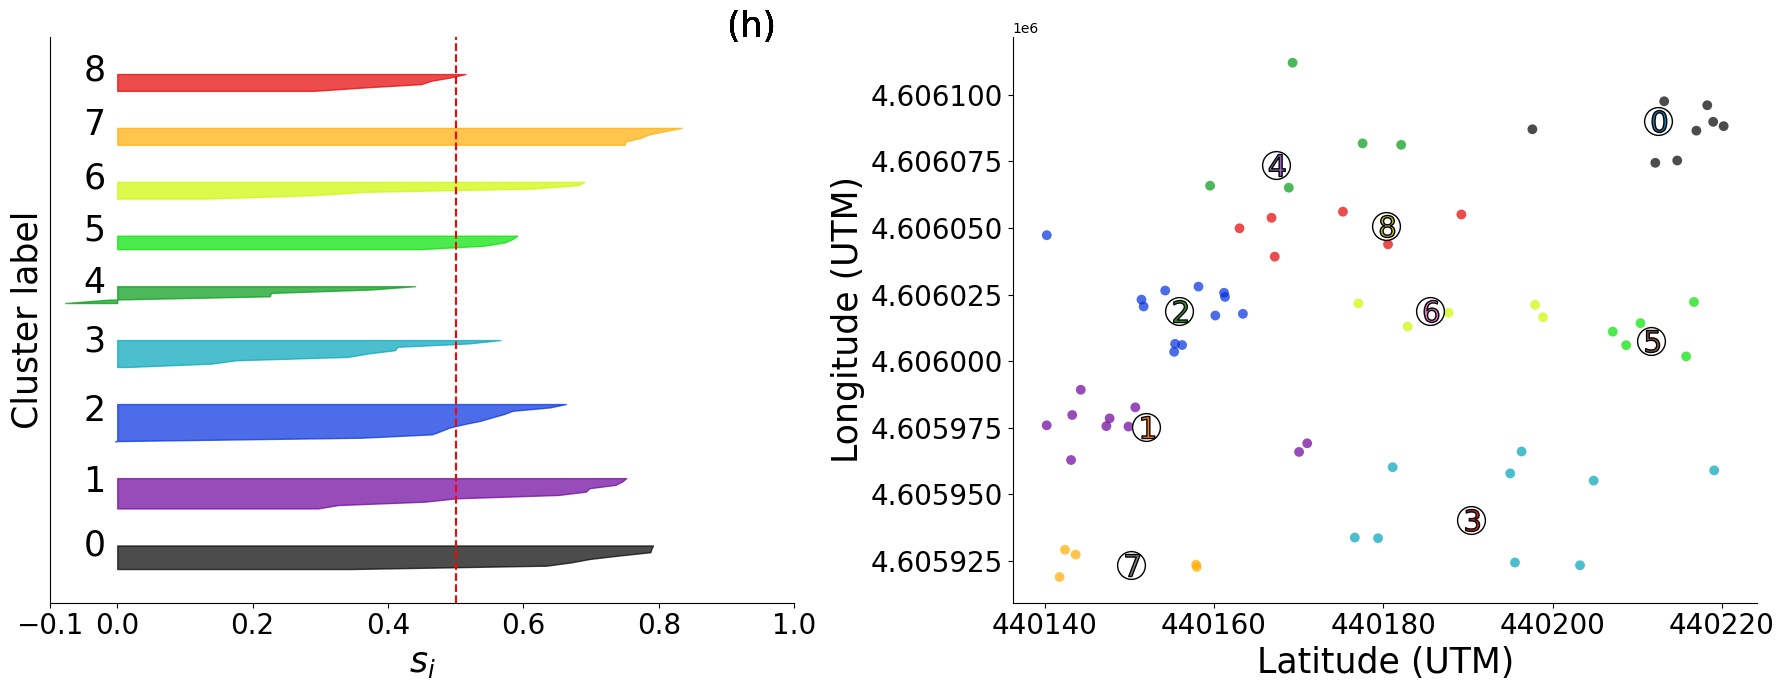

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For k = 10 The average silhouette_score is : 0.4849945503697654


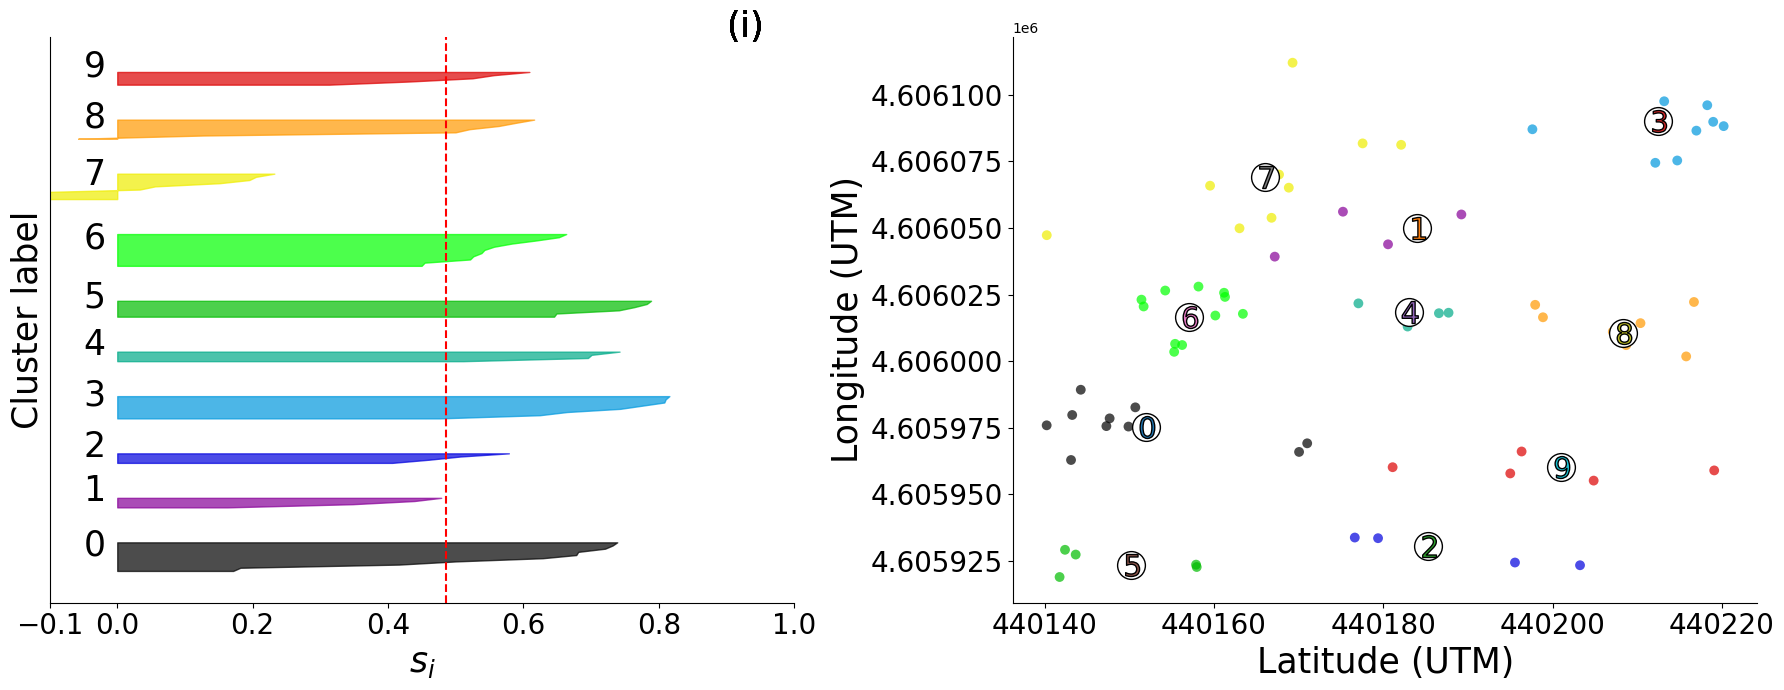

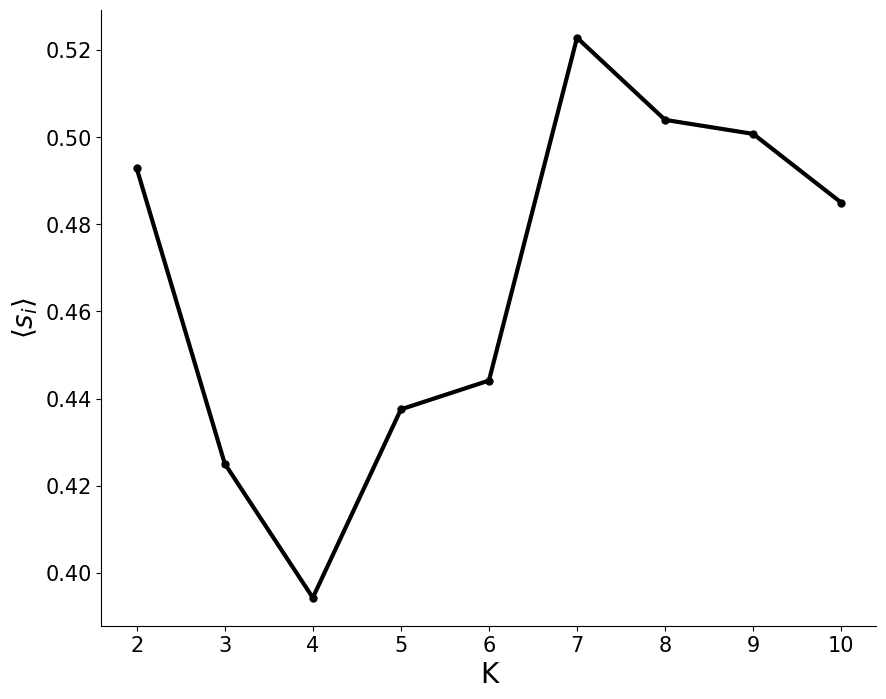

In [66]:
# number of clusters k=2,..,10

ks_list = []
silhouette_avg_list=[]
for ks in range(2,11):
    
    kmeans_weighted = KMeans(ks,n_init=100)   # each k-means is applied 500 times in order to find the optimal initial centroids
    kmeans_weighted.fit(x,sample_weight=x_weight)  # use the latitude and longitude (UTM projected) and the weights (duration)
    identified_weighted_clusters = kmeans_weighted.predict(x,sample_weight = x_weight)
            
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x) + (ks + 1) * 10])

    
    # The silhouette_score gives the average value for all the samples 
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(x, identified_weighted_clusters)
    print("For k =",ks,"The average silhouette_score is :",silhouette_avg)
    silhouette_avg_list.append(silhouette_avg)
    ks_list.append(ks)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x, identified_weighted_clusters)
    
    
    y_lower = 10
    for i in range(ks):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[identified_weighted_clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / ks)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),fontsize=25)
        
        if ks==2:
            ax1.text(0.9,len(x) + (ks + 1) * 10,'(a)',fontsize=25)

        if ks==3:
            ax1.text(0.9,len(x) + (ks + 1) * 10,'(b)',fontsize=25)
            
        if ks==4:
            ax1.text(0.9,len(x) + (ks + 1) * 10,'(c)',fontsize=25)
            
        if ks==5:
            ax1.text(0.9,len(x) + (ks + 1) * 10,'(d)',fontsize=25)
            
        if ks==6:
            ax1.text(0.9,len(x) + (ks + 1) * 10,'(e)',fontsize=25)     
            
        if ks==7:
            ax1.text(0.9,len(x) + (ks + 1) * 10,'(f)',fontsize=25) 
                
        if ks==8:
            ax1.text(0.9,len(x) + (ks + 1) * 10,'(g)',fontsize=25)
                
        if ks==9:
            ax1.text(0.9,len(x) + (ks + 1) * 10,'(h)',fontsize=25)           
                
        if ks==10:
            ax1.text(0.9,len(x) + (ks + 1) * 10,'(i)',fontsize=25)
                     
                     
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel(r"$s_{i}$",fontsize=25)
    ax1.set_ylabel("Cluster label",fontsize=25)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.tick_params(axis='both', labelsize=20)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(identified_weighted_clusters.astype(float) / ks)
    ax2.scatter(
        x.iloc[:, 0], x.iloc[:, 1], marker=".", s=200, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = kmeans_weighted.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=400,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=250, edgecolor="k")

    #ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Latitude (UTM)",fontsize=25)
    ax2.set_ylabel("Longitude (UTM)",fontsize=25)
    ax2.tick_params(axis='both', labelsize=20)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    #plt.suptitle(
        #"Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        #% ks,
        #fontsize=14,
        #fontweight="bold",
    #)

    fig.tight_layout()
    plt.show()



fig, ax = plt.subplots(figsize=(10,8)) 
ax.plot(ks_list,silhouette_avg_list, '.-',c='black',linewidth=3,markersize=10)
ax.set_xlabel('K', fontsize=20)
ax.set_ylabel(r'$\langle s_{i}\rangle$', fontsize=20)
plt.tick_params(labelsize = 15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig('weighted_k_means_silhouette.pdf',format='pdf', bbox_inches='tight')

plt.show()  

### 1.1.3. Gap statistic method

The gap statistic compares the total within intra-cluster variation for different values of k with their expected values under null reference distribution of the data. The estimate of the optimal clusters will be value that maximize the gap statistic (i.e, that yields the largest gap statistic). This means that the clustering structure is far away from the random uniform distribution of points.


1. Cluster the observed data, varying the number of clusters from k = 1, …, kmax, and compute the corresponding total within intra-cluster variation Wk.

2. Generate B reference data sets with a random uniform distribution. Cluster each of these reference data sets with varying number of clusters k = 1, …, kmax, and compute the corresponding total within intra-cluster variation Wkb.  (choose B>100, usually 500)

3. Compute the estimated gap statistic as the deviation of the observed Wk value from its expected value Wkb under the null hypothesis: Gap(k)=1B∑b=1Blog(W∗kb)−log(Wk)

4. Compute also the standard deviation of the statistics.

5. Choose the number of clusters as the smallest value of k such that the gap statistic is within one standard deviation of the gap at k+1: Gap(k)≥Gap(k + 1)−sk + 1.



Iteration number 1. The number of optimal clusters is k = 7



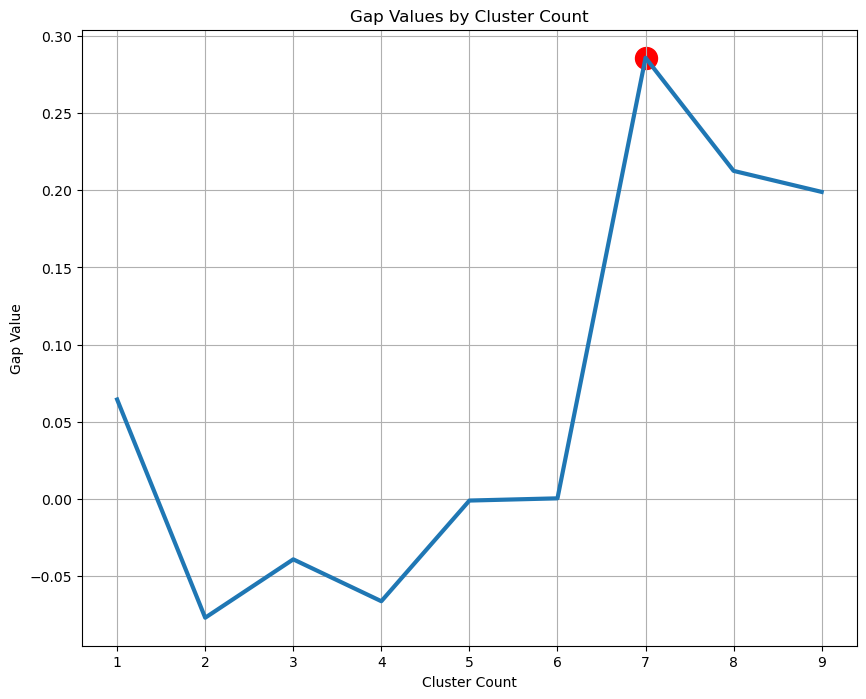



--------------------------------------------------------------------


Iteration number 2. The number of optimal clusters is k = 7



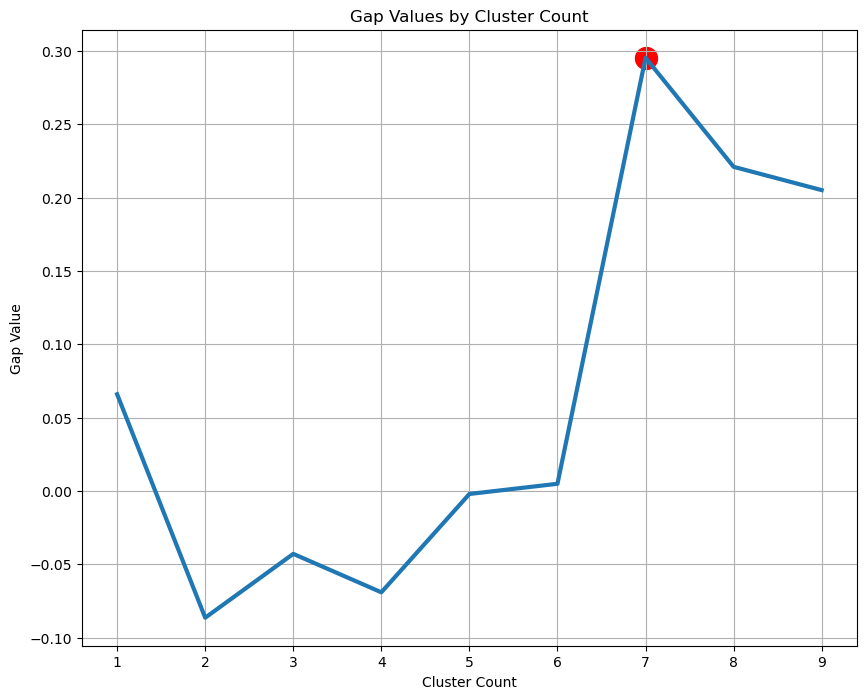



--------------------------------------------------------------------


Iteration number 3. The number of optimal clusters is k = 7



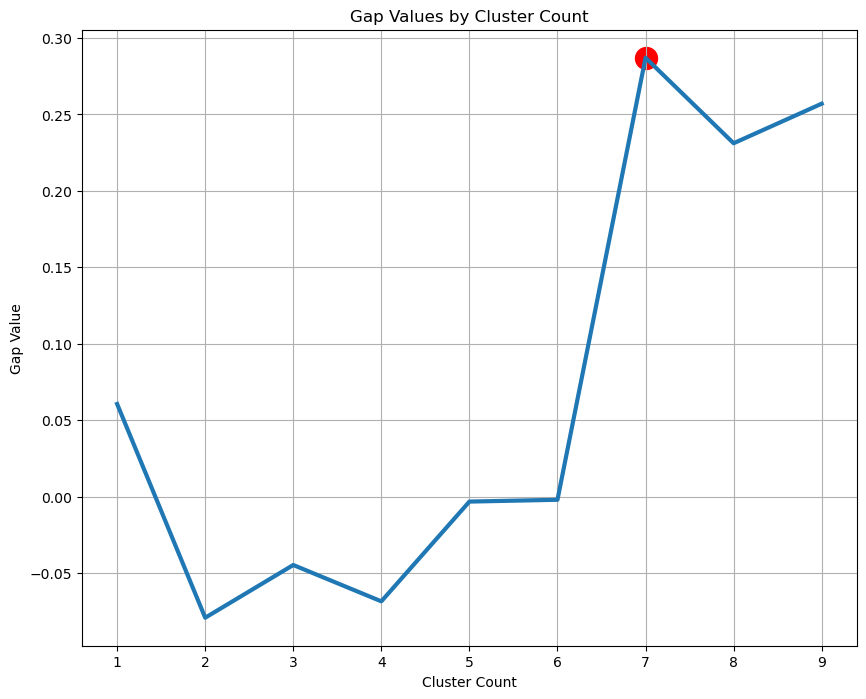



--------------------------------------------------------------------


Iteration number 4. The number of optimal clusters is k = 7



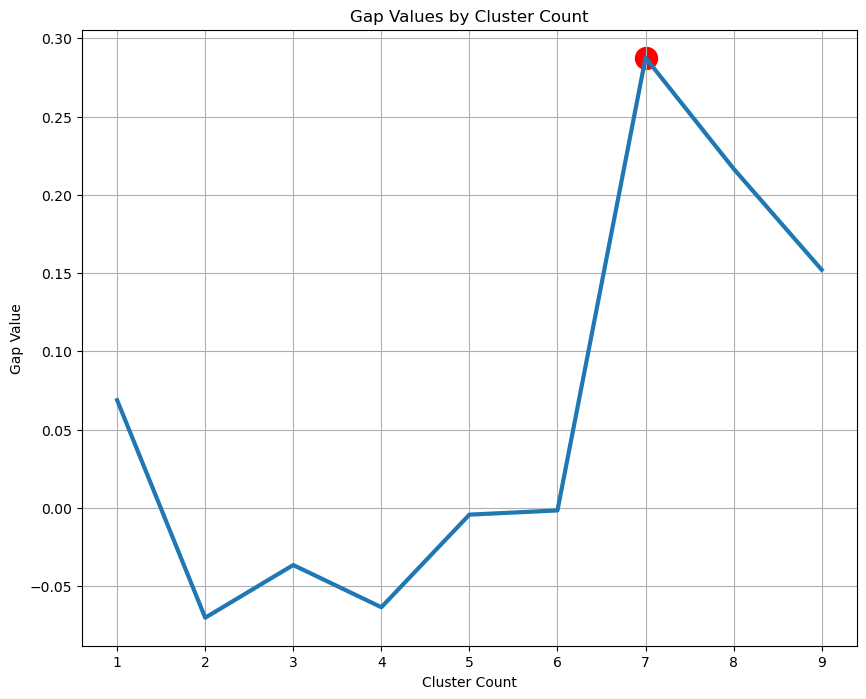



--------------------------------------------------------------------


Iteration number 5. The number of optimal clusters is k = 7



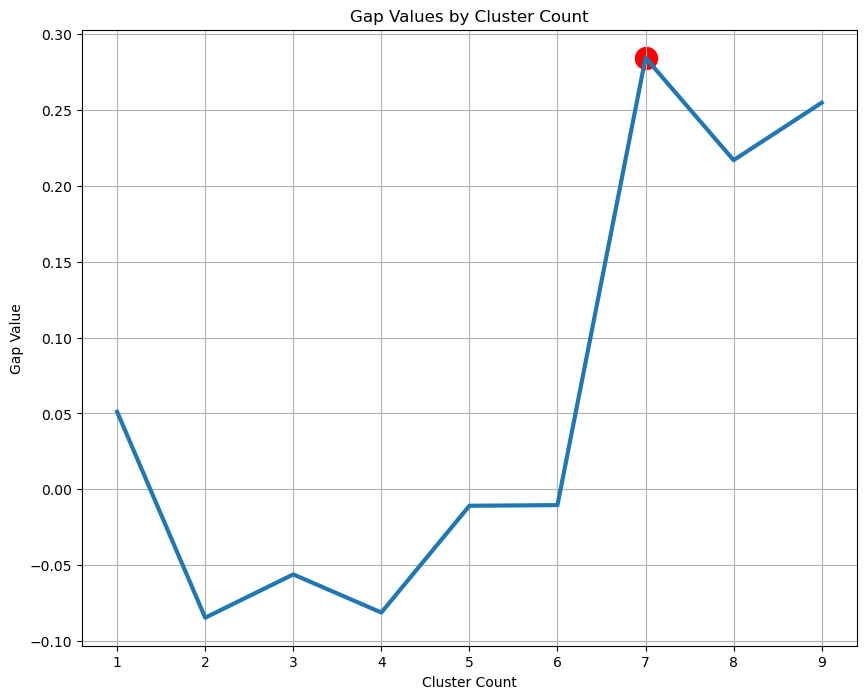



--------------------------------------------------------------------


Iteration number 6. The number of optimal clusters is k = 7



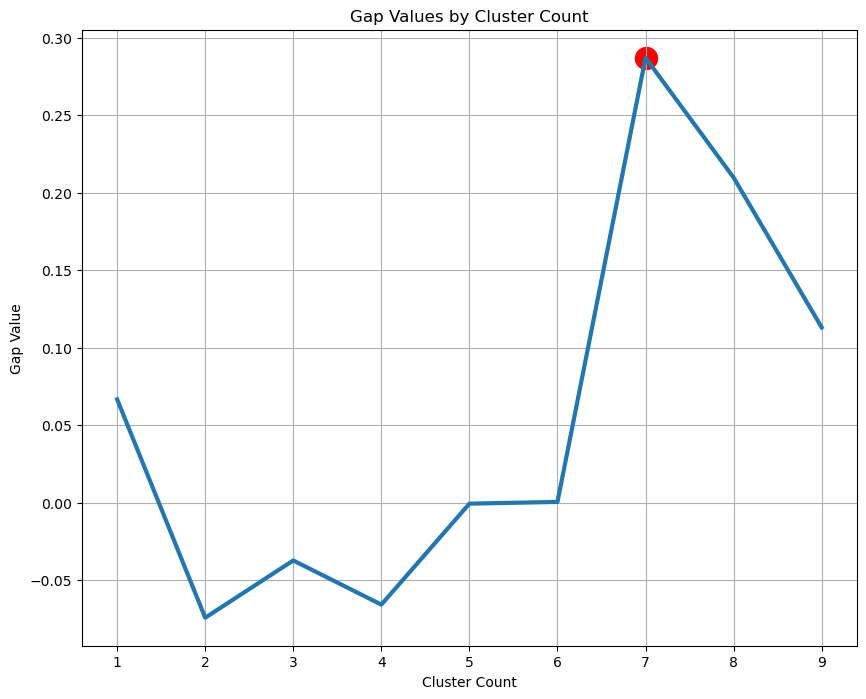



--------------------------------------------------------------------


Iteration number 7. The number of optimal clusters is k = 7



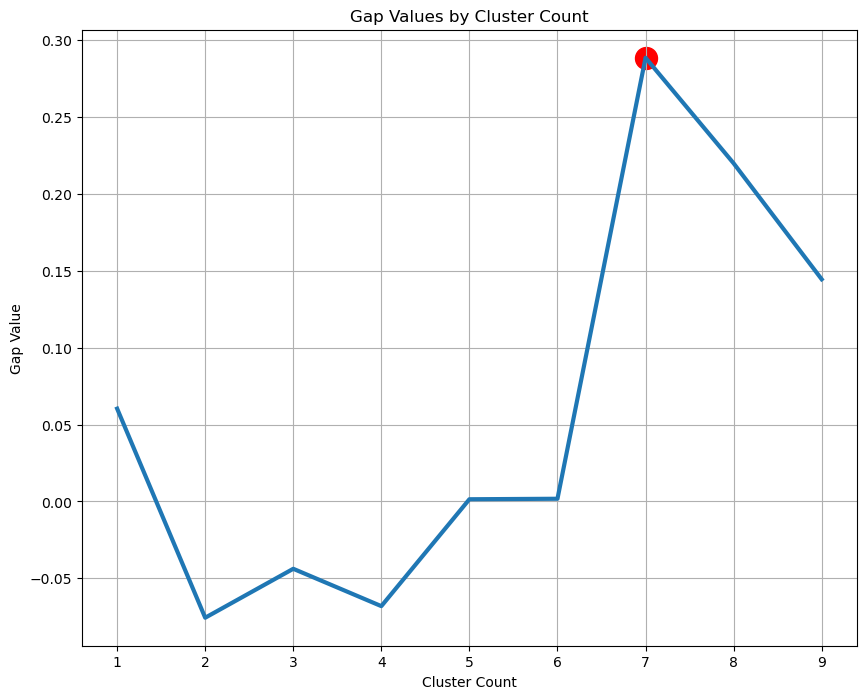



--------------------------------------------------------------------


Iteration number 8. The number of optimal clusters is k = 7



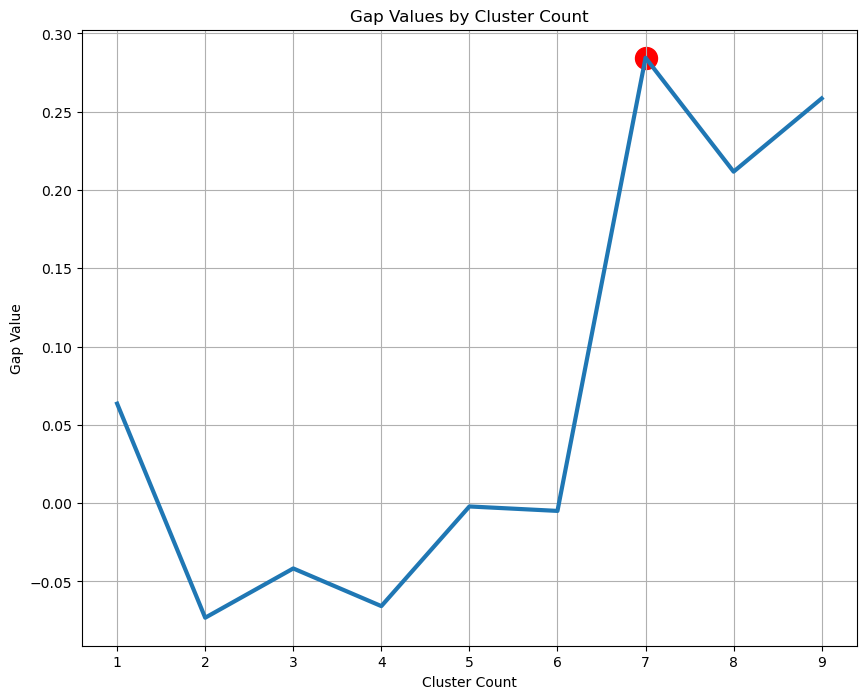



--------------------------------------------------------------------


Iteration number 9. The number of optimal clusters is k = 7



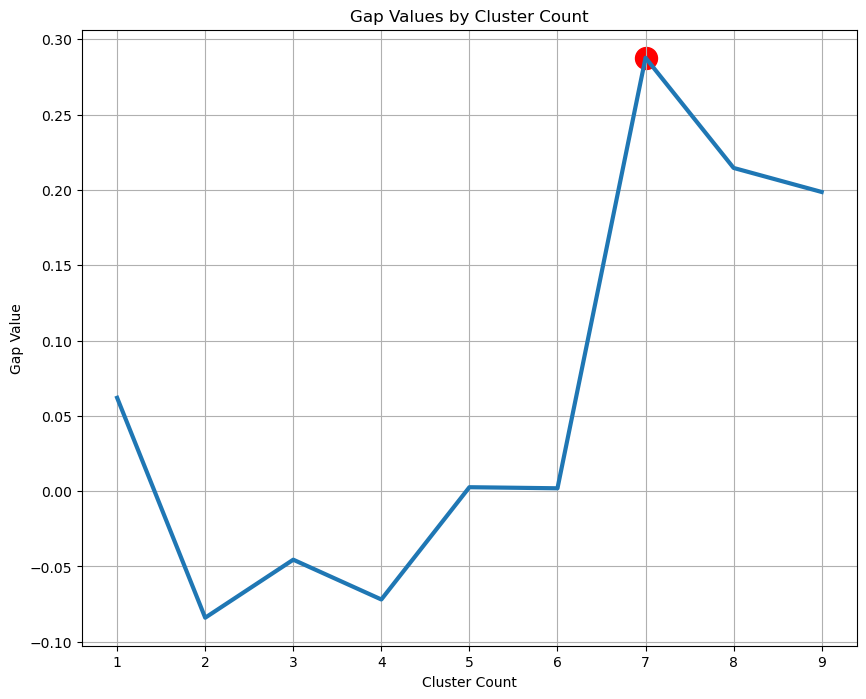



--------------------------------------------------------------------




In [69]:
# Run the GAP statistic method 50 times for robustness

n_clusters_list=[]
for i in range(1,10):
    
    # Define the OptimalK instance, but pass in our own clustering function
    optimalk = OptimalK(clusterer=weighted_kmeans)

    # Use the callable instance as normal.
    n_clusters = optimalk(x, n_refs=500, cluster_array=range(1, 10))
    
    print('Iteration number {}. The number of optimal clusters is k = {}'.format(i,n_clusters))
    print('')
    
    fig, ax = plt.subplots(figsize=(10,8)) 
    plt.plot(optimalk.gap_df.n_clusters, optimalk.gap_df.gap_value, linewidth=3)
    plt.scatter(optimalk.gap_df[optimalk.gap_df.n_clusters == n_clusters].n_clusters,
            optimalk.gap_df[optimalk.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
    plt.grid(True)
    plt.xlabel('Cluster Count')
    plt.ylabel('Gap Value')
    plt.title('Gap Values by Cluster Count')
    plt.show()
    
    print('')
    print('')
    print('--------------------------------------------------------------------')
    print('')
    print('')
    
    n_clusters_list.append(n_clusters)

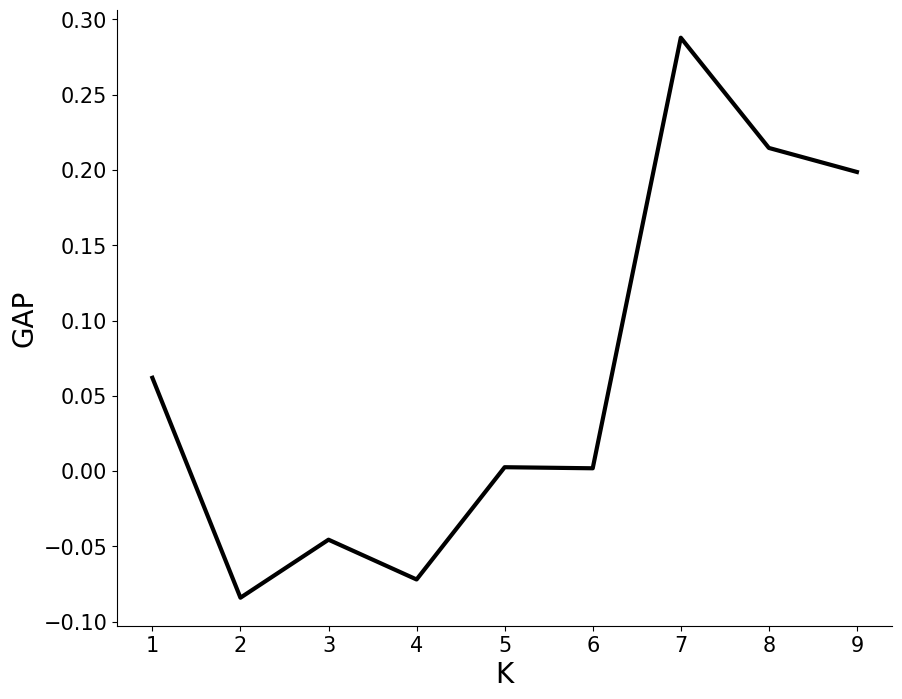

In [79]:
fig, ax = plt.subplots(figsize=(10,8)) 
ax.plot(optimalk.gap_df.n_clusters, optimalk.gap_df.gap_value, linewidth=3, color='k')
#ax.scatter(optimalk.gap_df[optimalk.gap_df.n_clusters == n_clusters].n_clusters,
    #optimalk.gap_df[optimalk.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')

#ax.axvline(x=7, ymin=0, ymax=0.92, linestyle='--', color='k')

#plt.grid(True)
plt.xlabel('K', fontsize=20)
plt.ylabel('GAP', fontsize=20)
#plt.title('Gap Values by Cluster Count')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(labelsize = 15)

#plt.savefig('weighted_k_means_gap.pdf',format='pdf', bbox_inches='tight')

plt.show()
            
      

<br>

## 1.2. Weighted K-Means Algorthim with K=7

We apply the weighted K-Means algorithm with k=7 clusters (with 100 different initial states/centroids)

In [7]:
kmeans_weighted7 = KMeans(7, n_init=100)
kmeans_weighted7.fit(x,sample_weight=x_weight)
identified_clusters_k7 = kmeans_weighted7.predict(x,sample_weight = x_weight)

data_with_clusters_k7 = df_stops_utm.copy()
data_with_clusters_k7['Clusters'] = identified_clusters_k7

#data_with_clusters_k7

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


#### Positions of the centroids

In [8]:
centroids  = kmeans_weighted7.cluster_centers_

# re-convert the positions of the centroids to lat, lon (degrees)
lat_lon = [utm.to_latlon(i[0],i[1],31,'T') for i in centroids]

latitude_centroids = [x[0] for x in lat_lon]
longitude_centroids = [x[1] for x in lat_lon]



####  Save the results

In [28]:
#data_with_clusters_k7.to_csv('weighted_kmeans_k7.csv',index=False)

### 1.2.1. Clusters representation

In [18]:
#data_with_clusters_k7 = pd.read_csv('weighted_kmeans_k7.csv')

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

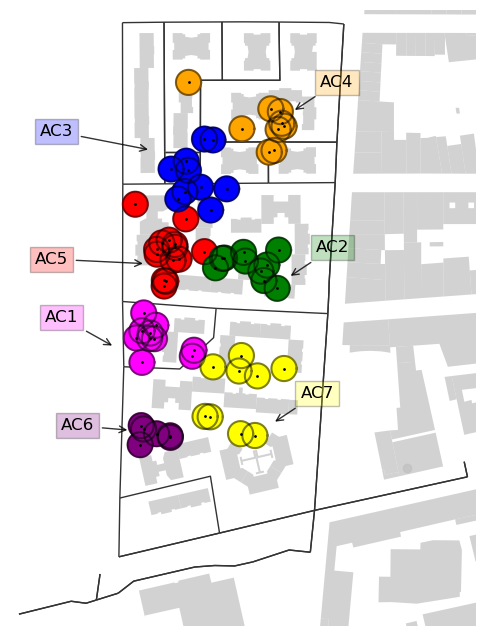

In [19]:
fig, ax = map_network(2.2804419490443517, 41.605107921345585, 2.28054397694062,41.60183248235341,  
                       2.283748215236327,41.602065783859004,  2.2840062702794897, 41.60530532450823)

lat_clusters_k7=data_with_clusters_k7['latitud'].tolist()
lon_clusters_k7=data_with_clusters_k7['longitud'].tolist()

for i in range(len(lon_clusters_k7)):
    a_k7=buffer_in_meters(lon_clusters_k7[i],lat_clusters_k7[i],9)
    x,y = a_k7.exterior.xy
            
    if data_with_clusters_k7['Clusters'][i]==0:
        plt.fill(x,y,color='yellow',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if data_with_clusters_k7['Clusters'][i]==1:
        plt.fill(x,y,color='blue',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)

    if data_with_clusters_k7['Clusters'][i]==2:
        plt.fill(x,y,color='red',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if data_with_clusters_k7['Clusters'][i]==3:
        plt.fill(x,y,color='magenta',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if data_with_clusters_k7['Clusters'][i]==4:
        plt.fill(x,y,color='purple',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if data_with_clusters_k7['Clusters'][i]==5:
        plt.fill(x,y,color='green',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if data_with_clusters_k7['Clusters'][i]==6:
        plt.fill(x,y,color='orange',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
    
    
plt.scatter(lon_clusters_k7, lat_clusters_k7, c='black', s=1,zorder=3)


bbox_args5 = dict(boxstyle='square',facecolor='red', edgecolor='k',alpha=0.25)
arrowprops5=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

bbox_args3 = dict(boxstyle='square',facecolor='blue', edgecolor='k',alpha=0.25)
arrowprops3=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

bbox_args4 = dict(boxstyle='square',facecolor='orange', edgecolor='k',alpha=0.25)
arrowprops4=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

bbox_args1 = dict(boxstyle='square',facecolor='magenta', edgecolor='k',alpha=0.25)
arrowprops1=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

bbox_args2 = dict(boxstyle='square',facecolor='green', edgecolor='k',alpha=0.25)
arrowprops2=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

bbox_args6 = dict(boxstyle='square',facecolor='purple', edgecolor='k',alpha=0.25)
arrowprops6=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

bbox_args7 = dict(boxstyle='square',facecolor='yellow', edgecolor='k',alpha=0.25)
arrowprops7=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

plt.annotate('AC5', (2.2817169120967007, 41.60360456286429),c='black',size=12,
                 bbox=bbox_args5,arrowprops=arrowprops5, xytext=(-80, 0),textcoords='offset points')

plt.annotate('AC3', (2.281749174140357, 41.60415027398868),c='black',size=12,
                 bbox=bbox_args3,arrowprops=arrowprops3, xytext=(-80, 10),textcoords='offset points')

plt.annotate('AC4', ( 2.282659600071432, 41.604334875302996),c='black',size=12,
                 bbox=bbox_args4,arrowprops=arrowprops4, xytext=(20, 18),textcoords='offset points')

plt.annotate('AC1', (2.2815169120967007, 41.60320456286429),c='black',size=12,
                 bbox=bbox_args1,arrowprops=arrowprops1, xytext=(-50, 18),textcoords='offset points')

plt.annotate('AC2', (2.2826324305927323, 41.603538326385046),c='black',size=12,
                 bbox=bbox_args2,arrowprops=arrowprops2, xytext=(20, 18),textcoords='offset points')

plt.annotate('AC6', (2.2816169120967007, 41.60280456286429),c='black',size=12,
                 bbox=bbox_args6,arrowprops=arrowprops6, xytext=(-50, 0),textcoords='offset points')

plt.annotate('AC7', (2.2825324305927323, 41.602838326385046),c='black',size=12,
                 bbox=bbox_args7,arrowprops=arrowprops7, xytext=(20, 18),textcoords='offset points')


#plt.savefig('k_means_6_weighted.pdf',format='pdf', bbox_inches='tight')

#plt.savefig('clustering_aturades_ponderades.eps')

plt.show()

### 1.2.2. Cluster analysis

Counts and statistics of each cluster

C:\Users\josep\AppData\Local\Temp\ipykernel_74380\1618496352.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=data_with_clusters_k7['Segment'], data=data_with_clusters_k7,order = data_with_clusters_k7['Segment'].value_counts().index, palette=colors)


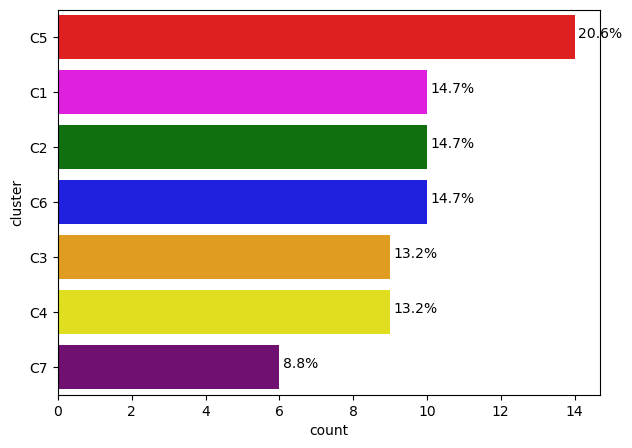

Segment
C5    14
C1    10
C2    10
C6    10
C3     9
C4     9
C7     6
Name: count, dtype: int64

In [24]:
#list_labels=['C1','C3','C5','C4','C2']  
import seaborn as sns

# Order the cluster
data_with_clusters_k7['Segment'] = data_with_clusters_k7['Clusters'].map({0:'C3', 1:'C1', 2:'C5', 3:'C2', 4:'C7', 5:'C6', 6:'C4'})
data_with_clusters_k7['Segment'] = data_with_clusters_k7['Segment'].astype('category')
#df3['Segment'] = df3['Segment'].cat.reorder_categories(['C1','C2','C3', 'C4', 'C5'])

# Color cluster
data_with_clusters_k7['Cluster_color'] = data_with_clusters_k7['Clusters'].map({0:'blue', 1:'magenta', 2:'red', 3:'green', 4:'yellow', 5:'purple', 6:'orange'})
data_with_clusters_k7['Cluster_color'] = data_with_clusters_k7['Cluster_color'].astype('category')


plt.figure(figsize=(7,5))
colors=['red','magenta','green','blue','orange','yellow','purple' ]
ax = sns.countplot(y=data_with_clusters_k7['Segment'], data=data_with_clusters_k7,order = data_with_clusters_k7['Segment'].value_counts().index, palette=colors)
plt.xlabel('count')
plt.ylabel('cluster')


total = sum(data_with_clusters_k7['Segment'].value_counts())
for pp in ax.patches:
    percentage = '{:.1f}%'.format(100 * pp.get_width()/total)
    value=pp.get_width()
    x = pp.get_x() + pp.get_width() + 0.1
    y = pp.get_y() + pp.get_height()/2
    ax.annotate(percentage, (x, y))
    
plt.show()

data_with_clusters_k7['Segment'].value_counts()


#data_with_clusters_k7.to_csv('weighted_kmeans_k7.csv')

In [23]:
for i,j in data_with_clusters_k7.groupby('Segment'):
    print(i)
    print('')
    print('num aturades:',len(j['durada']))
    print('temps total:', sum(j['durada']))
    print('temps promig:',j['durada'].mean(), '+-', j['durada'].std()/np.sqrt(len(j['durada'])))
    print('desviacio estandard',j['durada'].std())
    print('temps minim',min(j['durada']))
    print('temps maxim',max(j['durada']))
    print('')
    print('------------------------')
    print('')

C1

num aturades: 10
temps total: 11786.0
temps promig: 1178.6 +- 270.1729569491859
desviacio estandard 854.361906142044
temps minim 96.0
temps maxim 2677.0

------------------------

C2

num aturades: 10
temps total: 8083.0
temps promig: 808.3 +- 201.86376318915904
desviacio estandard 638.3492687305977
temps minim 100.0
temps maxim 1955.0

------------------------

C3

num aturades: 9
temps total: 5650.0
temps promig: 627.7777777777778 +- 261.5176209156521
desviacio estandard 784.5528627469563
temps minim 39.0
temps maxim 2669.0

------------------------

C4

num aturades: 9
temps total: 4999.0
temps promig: 555.4444444444445 +- 103.70820592078836
desviacio estandard 311.12461776236506
temps minim 100.0
temps maxim 963.0

------------------------

C5

num aturades: 14
temps total: 7661.0
temps promig: 547.2142857142857 +- 150.49986961300726
desviacio estandard 563.1189488460236
temps minim 87.0
temps maxim 2345.0

------------------------

C6

num aturades: 10
temps total: 10532.0
tem

<br>

# 2. Unweighted K-Means Algorthim

Repeat the process above using the unweigthed version of the K-Means algorithm, for robustness. 



##  2.1. Unweighted K-Means Algorithm with K=7

In [29]:
kmeans_unweighted7 = KMeans(7, n_init=100)
kmeans_unweighted7.fit(x)
identified_unweighted_clusters_k7 = kmeans_unweighted7.predict(x)

data_with_clusters_unweighted_k7 = df_stops_utm.copy()
data_with_clusters_unweighted_k7['Clusters'] = identified_unweighted_clusters_k7


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

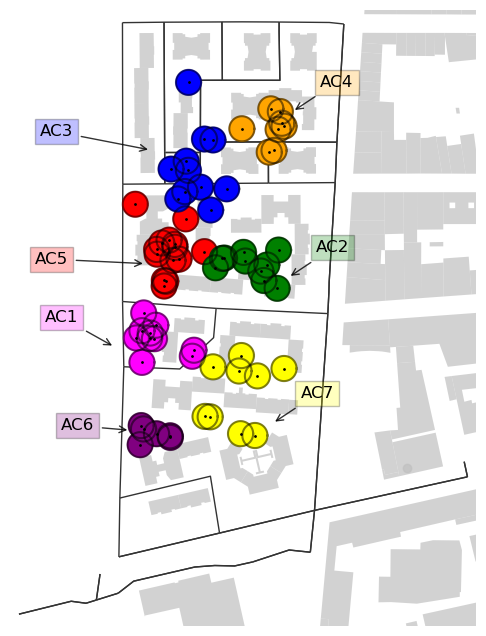

In [38]:
fig, ax = map_network(2.2804419490443517, 41.605107921345585, 2.28054397694062,41.60183248235341,  
                       2.283748215236327,41.602065783859004,  2.2840062702794897, 41.60530532450823)

lat_clusters_k7=data_with_clusters_unweighted_k7['latitud'].tolist()
lon_clusters_k7=data_with_clusters_unweighted_k7['longitud'].tolist()

for i in range(len(lon_clusters_k7)):
    a_k7=buffer_in_meters(lon_clusters_k7[i],lat_clusters_k7[i],9)
    x,y = a_k7.exterior.xy
            
    if data_with_clusters_unweighted_k7['Clusters'][i]==0:
        plt.fill(x,y,color='orange',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if data_with_clusters_unweighted_k7['Clusters'][i]==1:
        plt.fill(x,y,color='magenta',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)

    if data_with_clusters_unweighted_k7['Clusters'][i]==2:
        plt.fill(x,y,color='red',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if data_with_clusters_unweighted_k7['Clusters'][i]==3:
        plt.fill(x,y,color='yellow',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if data_with_clusters_unweighted_k7['Clusters'][i]==4:
        plt.fill(x,y,color='blue',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if data_with_clusters_unweighted_k7['Clusters'][i]==5:
        plt.fill(x,y,color='green',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if data_with_clusters_unweighted_k7['Clusters'][i]==6:
        plt.fill(x,y,color='purple',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
    
    
plt.scatter(lon_clusters_k7, lat_clusters_k7, c='black', s=1,zorder=3)


bbox_args5 = dict(boxstyle='square',facecolor='red', edgecolor='k',alpha=0.25)
arrowprops5=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

bbox_args3 = dict(boxstyle='square',facecolor='blue', edgecolor='k',alpha=0.25)
arrowprops3=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

bbox_args4 = dict(boxstyle='square',facecolor='orange', edgecolor='k',alpha=0.25)
arrowprops4=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

bbox_args1 = dict(boxstyle='square',facecolor='magenta', edgecolor='k',alpha=0.25)
arrowprops1=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

bbox_args2 = dict(boxstyle='square',facecolor='green', edgecolor='k',alpha=0.25)
arrowprops2=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

bbox_args6 = dict(boxstyle='square',facecolor='purple', edgecolor='k',alpha=0.25)
arrowprops6=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

bbox_args7 = dict(boxstyle='square',facecolor='yellow', edgecolor='k',alpha=0.25)
arrowprops7=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black',alpha=0.8)

plt.annotate('AC5', (2.2817169120967007, 41.60360456286429),c='black',size=12,
                 bbox=bbox_args5,arrowprops=arrowprops5, xytext=(-80, 0),textcoords='offset points')

plt.annotate('AC3', (2.281749174140357, 41.60415027398868),c='black',size=12,
                 bbox=bbox_args3,arrowprops=arrowprops3, xytext=(-80, 10),textcoords='offset points')

plt.annotate('AC4', ( 2.282659600071432, 41.604334875302996),c='black',size=12,
                 bbox=bbox_args4,arrowprops=arrowprops4, xytext=(20, 18),textcoords='offset points')

plt.annotate('AC1', (2.2815169120967007, 41.60320456286429),c='black',size=12,
                 bbox=bbox_args1,arrowprops=arrowprops1, xytext=(-50, 18),textcoords='offset points')

plt.annotate('AC2', (2.2826324305927323, 41.603538326385046),c='black',size=12,
                 bbox=bbox_args2,arrowprops=arrowprops2, xytext=(20, 18),textcoords='offset points')

plt.annotate('AC6', (2.2816169120967007, 41.60280456286429),c='black',size=12,
                 bbox=bbox_args6,arrowprops=arrowprops6, xytext=(-50, 0),textcoords='offset points')

plt.annotate('AC7', (2.2825324305927323, 41.602838326385046),c='black',size=12,
                 bbox=bbox_args7,arrowprops=arrowprops7, xytext=(20, 18),textcoords='offset points')


#plt.savefig('unweighted_k_means_7.pdf',format='pdf', bbox_inches='tight')

#plt.savefig('clustering_aturades_ponderades.eps')

plt.show()

In [35]:
data_with_clusters_unweighted_k7['Segment'] = data_with_clusters_unweighted_k7['Clusters'].map({0:'C3', 1:'C1', 2:'C5', 3:'C2', 4:'C7', 5:'C6', 6:'C4'})
data_with_clusters_unweighted_k7['Segment'] = data_with_clusters_unweighted_k7['Segment'].astype('category')

for i,j in data_with_clusters_unweighted_k7.groupby('Segment'):
    print(i)
    print('')
    print('num aturades:',len(j['durada']))
    print('temps total:', sum(j['durada']))
    print('temps promig:',j['durada'].mean(), '+-', j['durada'].std()/np.sqrt(len(j['durada'])))
    print('desviacio estandard',j['durada'].std())
    print('temps minim',min(j['durada']))
    print('temps maxim',max(j['durada']))
    print('')
    print('------------------------')
    print('')

C1

num aturades: 10
temps total: 8083.0
temps promig: 808.3 +- 201.86376318915904
desviacio estandard 638.3492687305977
temps minim 100.0
temps maxim 1955.0

------------------------

C2

num aturades: 9
temps total: 5650.0
temps promig: 627.7777777777778 +- 261.5176209156521
desviacio estandard 784.5528627469563
temps minim 39.0
temps maxim 2669.0

------------------------

C3

num aturades: 8
temps total: 4480.0
temps promig: 560.0 +- 117.48054550191945
desviacio estandard 332.285161527608
temps minim 100.0
temps maxim 963.0

------------------------

C4

num aturades: 6
temps total: 4349.0
temps promig: 724.8333333333334 +- 162.081752348759
desviacio estandard 397.01758987060845
temps minim 262.0
temps maxim 1243.0

------------------------

C5

num aturades: 14
temps total: 7661.0
temps promig: 547.2142857142857 +- 150.49986961300726
desviacio estandard 563.1189488460236
temps minim 87.0
temps maxim 2345.0

------------------------

C6

num aturades: 10
temps total: 10532.0
temps 